In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)
plt.set_cmap("viridis")

import itertools
import numpy as np

In [ ]:
from carl.distributions import Normal
from carl.data import GK
gk = GK(A=3., B=1., g=2., k=0.5)
X_true = gk.rvs(10000)
p1 = Normal(mu=np.mean(X_true), sigma=np.std(X_true) * 3)

In [ ]:
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

params = [(gk.A, np.linspace(0, 4, num=15)), 
          (gk.B, np.linspace(0, 4, num=15)[1:])]
X, y = make_parameterized_classification(gk, p1, 100000, params)
clf = ParameterizedClassifier(make_pipeline(StandardScaler(), 
                                            as_classifier(MLPRegressor(learning_rate="adaptive"))),
                              [gk.A, gk.B])
clf.fit(X, y)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV

def objective(X, theta, random_state=0):
    # Set parameter values
    gk.A.set_value(theta[0])
    gk.B.set_value(theta[1])
    gk.g.set_value(theta[2])
    gk.k.set_value(theta[3])
    
    gk.set_params(random_state=random_state)
    p1.set_params(random_state=random_state+1)
    
    # Calibrate local predictions
    local_clf = CalibratedClassifierCV(base_estimator=clf, 
                                       cv="prefit", 
                                       method="isotonic")
    X0 = gk.rvs(3750)
    X1 = p1.rvs(3750)
    y = np.zeros(len(X0) + len(X1))
    y[len(X0):] = 1
    local_clf.fit(np.vstack((X0, X1)), y)
    
    # Evaluate ratio
    p = local_clf.predict_proba(X)[:, 0]
    r = np.log(p) - np.log(1. - p)

    return -np.mean(r[np.isfinite(r)])

def bootstrap(n_trials, X, func, **kwargs):
    scores = []
    
    for i in range(n_trials):
        indices = np.random.randint(0, len(X), len(X))
        scores.append(func(X[indices], random_state=i, **kwargs))
        
    return np.mean(scores)

In [ ]:
# Scan
As = np.linspace(0, 4, num=20)
Bs = np.linspace(0, 4, num=20)[1:]
values = [-bootstrap(3, X_true, objective, theta=[A, B, 2, 0.5]) for A, B in itertools.product(As, Bs)]

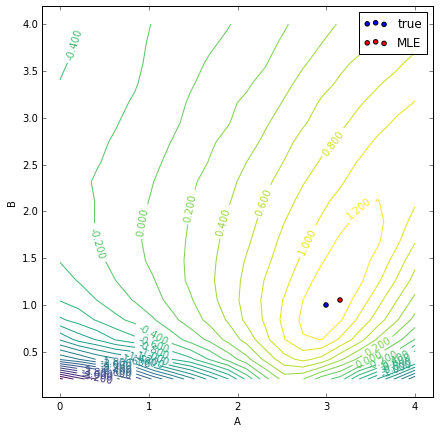

In [8]:
# Contour plot
AA, BB = np.meshgrid(As, Bs)
CS = plt.contour(AA, BB, np.array(values).reshape((len(As), len(Bs))).T, 30)
plt.clabel(CS, inline=1, fontsize=10)

best_A = As[np.argmax(values) // len(Bs)]
best_B = Bs[np.argmax(values) % len(Bs)]

plt.xlabel("A")
plt.ylabel("B")

plt.scatter([3], [1], label="true")
plt.scatter([best_A], [best_B], c="r", label="MLE")
plt.legend()

plt.show()